In [1]:
import pandas as pd
from lxml import etree

import matplotlib.pyplot as plt
from pprint import pprint

import networkx as nx
import pydot
from networkx.drawing.nx_pydot import graphviz_layout

In [2]:
path = '../data/drugbank_partial_and_generated.xml'
ns = {'db': 'http://www.drugbank.ca'}
tree = etree.parse(path)
root = tree.getroot()

In [3]:
def unwrap(field, node: etree._Element):
    if node is None:
        return None
    return getattr(node.find(f"db:{field}", ns), "text", None)

def unwrap_attrib(attrib, node: etree._Element):
    if node is None:
        return None
    return node.attrib.get(attrib)

### Zadanie 1

In [4]:
data = []
for drug in root.findall('db:drug', ns):
    drug_id = drug.find('db:drugbank-id', ns).text
    name = drug.find('db:name', ns).text
    drug_type = drug.attrib.get('type', None)
    description = drug.find('db:description', ns).text
    description = drug.find('db:description', ns).text
    indications = drug.find('db:indication', ns).text
    mechanism_of_action = drug.find('db:mechanism-of-action', ns).text
    food_interactions = [interaction.text for interaction in drug.findall('db:food-interactions/db:food-interaction', ns)]
    
    data.append({
        "DrugBank ID": drug_id,
        "Name": name,
        "Type": drug_type,
        "Description": description,
        "Indications": indications,
        "Mechanism of Action": mechanism_of_action,
        "Food Interactions": ", ".join(food_interactions),
    })

df = pd.DataFrame(data)
df

,DrugBank ID,Name,Type,Description,Indications,Mechanism of Action,Food Interactions
0,DB00001,Lepirudin,biotech,Lepirudin is a recombinant hirudin formed by 6...,Lepirudin is indicated for anticoagulation in ...,Lepirudin is a direct thrombin inhibitor used ...,Avoid herbs and supplements with anticoagulant...
1,DB00002,Cetuximab,biotech,Cetuximab is a recombinant chimeric human/mous...,Cetuximab indicated for the treatment of local...,The epidermal growth factor receptor (EGFR) is...,
2,DB00003,Dornase alfa,biotech,Dornase alfa is a biosynthetic form of human d...,Used as adjunct therapy in the treatment of cy...,Dornase alfa is a biosynthetic form of human D...,
3,DB00004,Denileukin diftitox,biotech,A recombinant DNA-derived cytotoxic protein co...,For treatment of cutaneous T-cell lymphoma,Denileukin diftitox binds to the high-affinity...,
4,DB00005,Etanercept,biotech,Dimeric fusion protein consisting of the extra...,Etanercept is indicated for the treatment of m...,There are two distinct receptors for TNF (TNFR...,
...,...,...,...,...,...,...,...
19995,19895,Interferon alfa-n3,biotech,Human erythropoietin with 2 aa substitutions t...,Human immunoglobulin G is indicated for the fo...,Binds to the beta platelet-derived growth fact...,
19996,19896,Urokinase,biotech,"In 2002, botulinum toxin A, also known as onab...","For the treatment of dwarfism, prevention of H...",Botulinum toxin is a 150-kDa molecular weight ...,
19997,19897,Sermorelin,biotech,Recombinant Coagulation Factor IX is a purifie...,For the treatment of type I and II diabetes me...,Sermorelin binds to the growth hormone releasi...,
19998,19898,Muromonab,biotech,"A synthetic nonapeptide comprising cysteinyl, ...",Pegaspargase is indicated as a component of a ...,Aldesleukin binds to the IL-2 receptor which l...,


### Zadanie 2

In [5]:
index = []
data = []
for drug in root.findall('db:drug', ns):
    drug_id = drug.find('db:drugbank-id', ns).text
    name = drug.find('db:name', ns).text
    synonyms = [s.text for s in drug.findall('db:synonyms/db:synonym', ns)]

    index.append(drug_id)
    data.append({
        "Name": name,
        "Synonyms": synonyms,
    })

df = pd.DataFrame(data, index=index)
df

,Name,Synonyms
DB00001,Lepirudin,"[[Leu1, Thr2]-63-desulfohirudin, Desulfatohiru..."
DB00002,Cetuximab,"[Cetuximab, Cétuximab, Cetuximabum]"
DB00003,Dornase alfa,[Deoxyribonuclease (human clone 18-1 protein m...
DB00004,Denileukin diftitox,"[Denileukin, Denileukin diftitox, Interleukin-..."
DB00005,Etanercept,"[Etanercept, etanercept-szzs, etanercept-ykro,..."
...,...,...
19895,Interferon alfa-n3,"[Abciximab, Folitropina alfa, Daptomicina, Act..."
19896,Urokinase,"[AbobotulinumtoxinA, Indium (111In) satumomab ..."
19897,Sermorelin,[Basiliximab]
19898,Muromonab,"[24-163 fibroblast growth factor 7 (human), In..."


In [6]:
def synonym_graph(drug_id):
    graph = nx.Graph()
    name = df.loc[drug_id]["Name"]
    graph.add_node(name)
    for synonym in df.loc[drug_id]["Synonyms"]:
        if name != synonym:
            graph.add_edge(name, synonym)

    return graph

def draw_synonyms(drug_id):
    graph = synonym_graph(drug_id)
    
    plt.figure(figsize=(10, 10))
    pos = nx.spring_layout(graph, k=0.1, seed=2137)
    nx.draw(
        graph,
        pos,
        with_labels=True,
        node_size=3000, 
        font_size=10,
        node_color="#dddddd",
        edge_color="#aaaaaa",
        font_weight="bold"
    )
    plt.show()

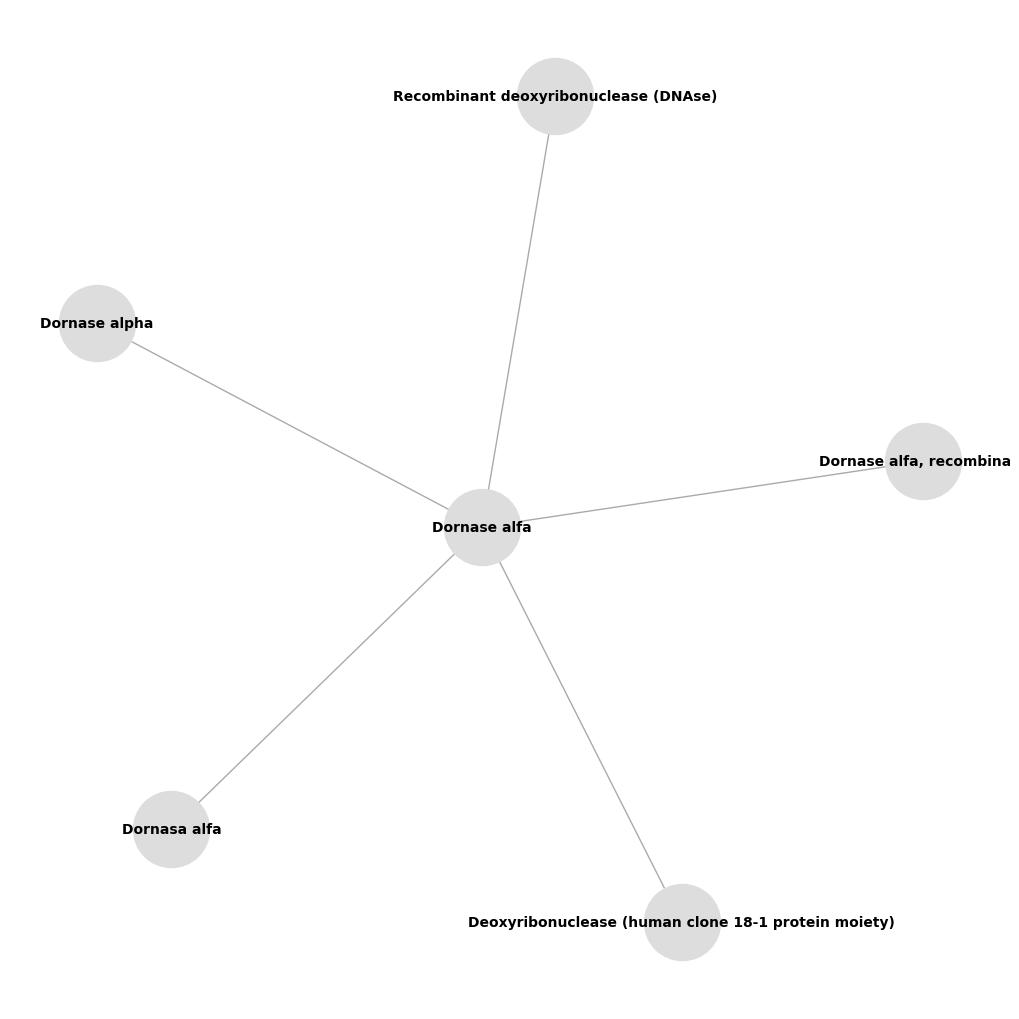

In [7]:
# example usage
draw_synonyms("DB00003")

### Zadanie 3

In [10]:
def product_df(drug_id):
    data = []
    drug = root.find(f"db:drug[db:drugbank-id='{drug_id}']", ns)

    for product in drug.findall('db:products/db:product', ns):        
        data.append({
            "Product Name": unwrap("name", product),
            "Labeller": unwrap("labeller", product),
            "NDC ID": unwrap("ndc-id", product),
            "NDC code": unwrap("ndc-product-code", product),
            "Dosage Form": unwrap("dosage-form", product),
            "Route": unwrap("route", product),
            "Strength": unwrap("strength", product),
            "Country": unwrap("country", product),
            "Source": unwrap("source", product),
        })

    return pd.DataFrame(data)

In [11]:
product_df("DB00091")

,Product Name,Labeller,NDC ID,NDC code,Dosage Form,Route,Strength,Country,Source
0,Apo-cyclosporine Oral Solution,Apotex Corporation,None,None,Solution,Oral,100 mg / mL,Canada,DPD
1,Aqua-stasis,Dr Marc's Manufacturing And Sales,None,70414-201,Liquid,Ophthalmic,0.0005 g/100mL,US,FDA NDC
2,Cequa,"Sun Pharmaceutical Industries, Inc.",None,47335-506,Solution / drops,Ophthalmic; Topical,0.0009 g/1mL,US,FDA NDC
3,Cequa,"Sun Pharmaceutical Industries, Inc.",None,47335-507,Solution / drops,Ophthalmic; Topical,0.0009 mg/1mL,US,FDA NDC
4,Cequa,Sun Pharmaceutical Industries Limited,None,None,Solution,Ophthalmic,0.09 % w/v,Canada,DPD
...,...,...,...,...,...,...,...,...,...
106,Verkazia,Santen Oy,None,None,Emulsion,Ophthalmic,1 mg/ml,EU,EMA
107,Verkazia,Santen Oy,None,None,Emulsion,Ophthalmic,1 mg/ml,EU,EMA
108,Verkazia,Santen Oy,None,None,Emulsion,Ophthalmic,1 mg/ml,EU,EMA
109,Vevye,Novaliq GmbH,None,83339-002,Solution / drops,Ophthalmic,1 mg/1mL,US,FDA NDC


### Zadanie 4

In [12]:
def all_pathways_df():
    data = []
    for drug in root.findall('db:drug', ns):
        for pathway in drug.findall('db:pathways/db:pathway', ns):
            data.append({
                "Drug Name": unwrap("name", drug),
                "Pathway Name": unwrap("name", pathway),
                "SMPDB ID": unwrap("smpdb-id", pathway),
                "Category": unwrap("category", pathway),
            })

    return pd.DataFrame(data)

In [13]:
df = all_pathways_df()
df

,Drug Name,Pathway Name,SMPDB ID,Category
0,Lepirudin,Lepirudin Action Pathway,SMP0000278,drug_action
1,Cetuximab,Cetuximab Action Pathway,SMP0000474,drug_action
2,Bivalirudin,Bivalirudin Action Pathway,SMP0000277,drug_action
3,Alteplase,Alteplase Action Pathway,SMP0000280,drug_action
4,Urokinase,Urokinase Action Pathway,SMP0000284,drug_action
5,Reteplase,Reteplase Action Pathway,SMP0000285,drug_action
6,Anistreplase,Anistreplase Action Pathway,SMP0000281,drug_action
7,Tenecteplase,Tenecteplase Action Pathway,SMP0000283,drug_action
8,Abciximab,Abciximab Action Pathway,SMP0000265,drug_action
9,Eptifibatide,Eptifibatide Action Pathway,SMP0000266,drug_action


### Zadanie 5

In [14]:
def pathways_df():
    data = []
    for pathway in root.findall('db:drug/db:pathways/db:pathway', ns):
        drugs = [drug_name.text for drug_name in pathway.findall('db:drugs/db:drug/db:name', ns)]
        pathway_name = unwrap("name", pathway)
        data.append({
            "Pathway": pathway_name,
            "Drugs": drugs,
        })
    
    return pd.DataFrame(data)

In [15]:
df = pathways_df()
df

,Pathway,Drugs
0,Lepirudin Action Pathway,"[Lepirudin, Phylloquinone, Calcium]"
1,Cetuximab Action Pathway,[Cetuximab]
2,Bivalirudin Action Pathway,"[Bivalirudin, Phylloquinone, Calcium]"
3,Alteplase Action Pathway,"[Alteplase, Phylloquinone, Calcium]"
4,Urokinase Action Pathway,"[Urokinase, Phylloquinone, Calcium]"
5,Reteplase Action Pathway,"[Reteplase, Phylloquinone, Calcium]"
6,Anistreplase Action Pathway,"[Anistreplase, Phylloquinone, Calcium]"
7,Tenecteplase Action Pathway,"[Tenecteplase, Phylloquinone, Calcium]"
8,Abciximab Action Pathway,[Abciximab]
9,Eptifibatide Action Pathway,[Eptifibatide]


In [16]:
def pathways_graph():
    graph = nx.Graph()
    bottom = []
    
    for pathway in root.findall('db:drug/db:pathways/db:pathway', ns):
        pathway_name = unwrap("name", pathway)
        for drug in pathway.findall('db:drugs/db:drug', ns):
            drug_name = unwrap("name", drug)
            graph.add_edge(pathway_name, drug_name)
            bottom.append(drug_name)
    
    pos = nx.bipartite_layout(graph, bottom)
    plt.figure(figsize=(10, 10))
    nx.draw(
        graph,
        pos,
        with_labels=True,
        node_size=1000, 
        font_size=8,
        node_color="#dddddd",
        edge_color="#aaaaaa",
    )
    plt.show()
    

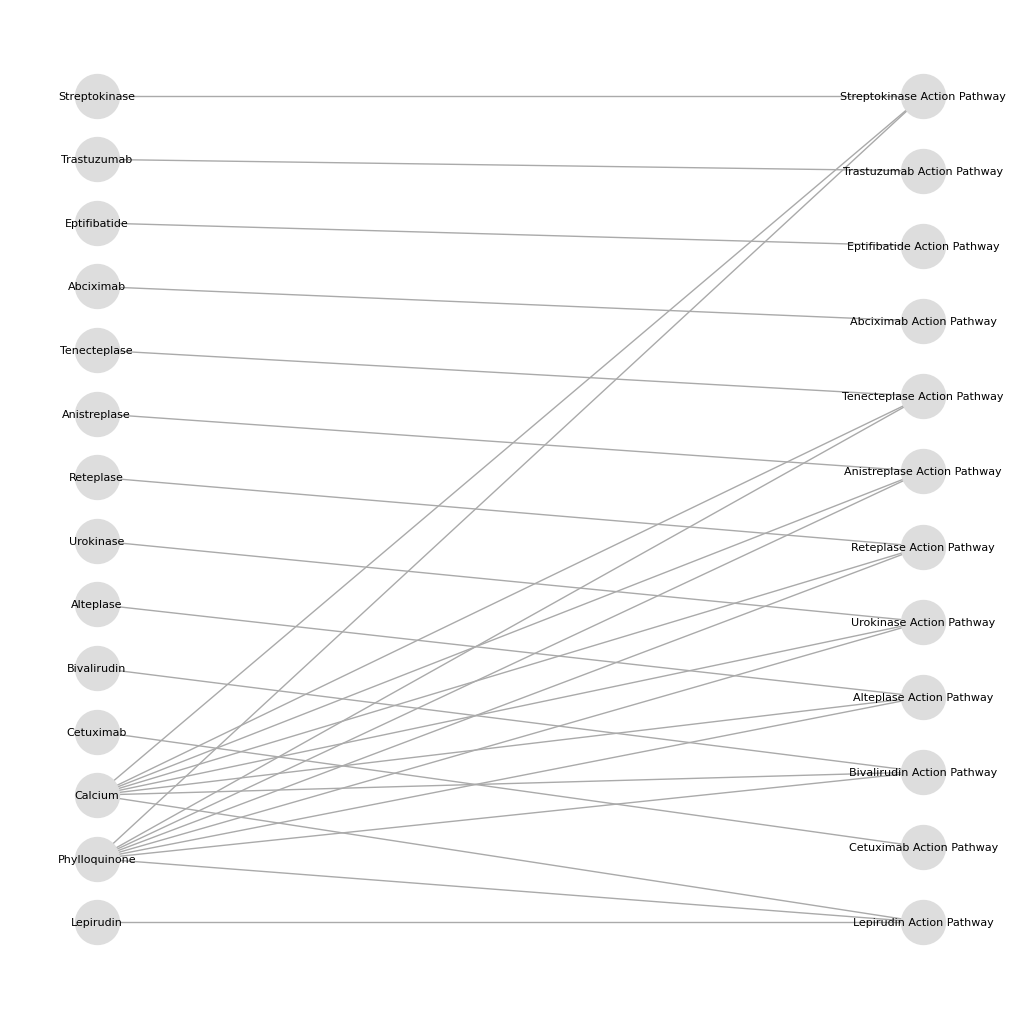

In [17]:
pathways_graph()

### Zadanie 6

In [18]:
def pathways_df2():
    data = {}
    for pathway in root.findall('db:drug/db:pathways/db:pathway', ns):
        pathway_name = unwrap("name", pathway)
        for drug in pathway.findall('db:drugs/db:drug', ns):
            drug_name = unwrap("name", drug)
            data.setdefault(drug_name, [])
            data[drug_name].append(pathway_name)
            
    # pprint(data)
    counts = {k: len(v) for (k, v) in data.items()}
    # pprint(counts)
    
    # Drawing histogram
    plt.figure(figsize=(10, 6))
    plt.bar(counts.keys(), counts.values())
    
    plt.xlabel('Drugs')
    plt.ylabel('Pathways count')
    plt.title('Drug-Pathway interaction Histogram')
    
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

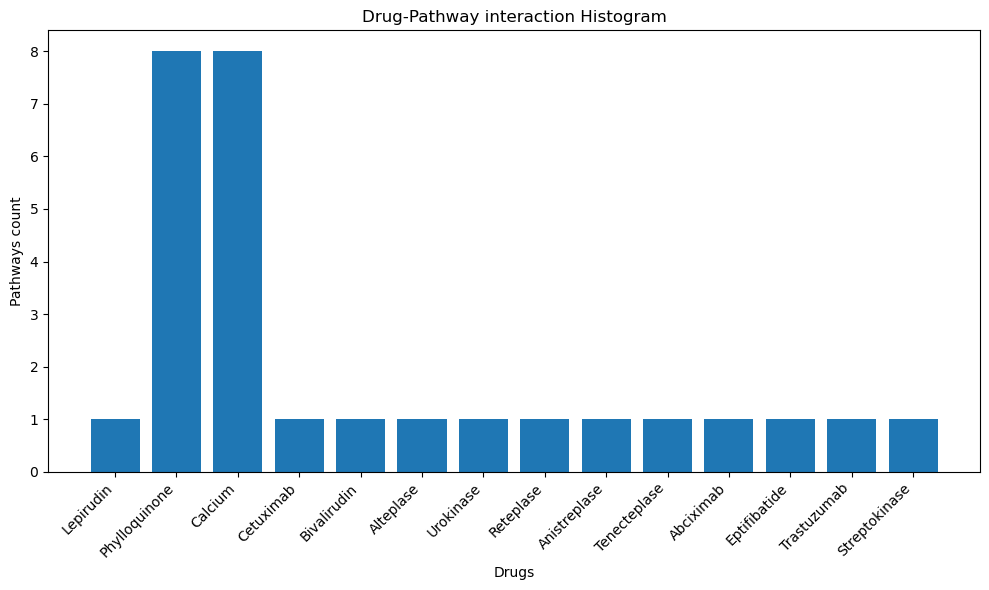

In [19]:
pathways_df2()

### Zadanie 7

In [20]:
def targets_df(drug_id):
    data = []
    for target in root.findall(f"db:drug[db:drugbank-id='{drug_id}']/db:targets/db:target", ns):
        polypeptide = target.find('db:polypeptide', ns)
        
        try:
            genatlas = polypeptide.find("db:external-identifiers/db:external-identifier[db:resource='GenAtlas']", ns)
        except Exception:
            genatlas = None

        data.append({
            "ID": unwrap("id", target),
            "Source": unwrap_attrib("source", polypeptide),
            "Source ID": unwrap_attrib("id", polypeptide),
            "Polypeptide Name": unwrap("name", polypeptide),
            "Gene Name": unwrap("gene-name", polypeptide),
            "GenAtlas ID": unwrap("identifier", genatlas),
            "Chromosome No": unwrap("chromosome-location", polypeptide),
            "Cellular Loc": unwrap("cellular-location", polypeptide),
        })
            
    return pd.DataFrame(data)

In [21]:
targets_df("DB00002")

,ID,Source,Source ID,Polypeptide Name,Gene Name,GenAtlas ID,Chromosome No,Cellular Loc
0,BE0000767,Swiss-Prot,P00533,Epidermal growth factor receptor,EGFR,EGFR,7,Cell membrane
1,BE0000901,Swiss-Prot,O75015,Low affinity immunoglobulin gamma Fc region re...,FCGR3B,FCGR3B,1,Cell membrane
2,BE0002094,Swiss-Prot,P02745,Complement C1q subcomponent subunit A,C1QA,C1QA,1,Secreted
3,BE0002095,Swiss-Prot,P02746,Complement C1q subcomponent subunit B,C1QB,C1QB,1,Secreted
4,BE0002096,Swiss-Prot,P02747,Complement C1q subcomponent subunit C,C1QC,C1QC,1,Secreted
...,...,...,...,...,...,...,...,...
542,BE0000203,Swiss-Prot,P14784,None,INSR,None,7,Cell membrane
543,BE0004834,Swiss-Prot,P31785,Erythropoietin receptor,ITGB3,None,10,Cell membrane
544,BE0000293,None,None,None,None,None,None,None
545,BE0000719,None,None,None,None,None,None,None


### Zadanie 8

In [22]:
def targets_pie(drug_id):
    drug = root.find(f"db:drug[db:drugbank-id='{drug_id}']", ns)
    counts = {}
    for polypeptide in drug.findall('db:targets/db:target/db:polypeptide', ns):
        cellular_loc = unwrap("cellular-location", polypeptide)
        counts.setdefault(cellular_loc, 0)
        counts[cellular_loc] += 1

    # Drawing pie chart
    plt.pie(counts.values(), labels=counts.keys(), autopct='%1.2f%%')
    plt.title(f"Cellular Location Distribution ({unwrap('name', drug)})")
    plt.show()

In [23]:
def targets_pie_all():
    counts = {}
    for polypeptide in root.findall(f"db:drug/db:targets/db:target/db:polypeptide", ns):
        cellular_loc = unwrap("cellular-location", polypeptide)
        counts.setdefault(cellular_loc, 0)
        counts[cellular_loc] += 1

    # Drawing pie chart
    plt.figure(figsize=(10, 10))
    plt.pie(counts.values(), labels=counts.keys(), autopct='%1.2f%%')
    plt.title("Cellular Location Distribution (All)")
    plt.show()

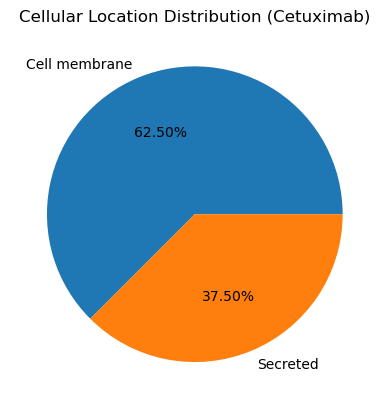

In [24]:
targets_pie("DB00002")

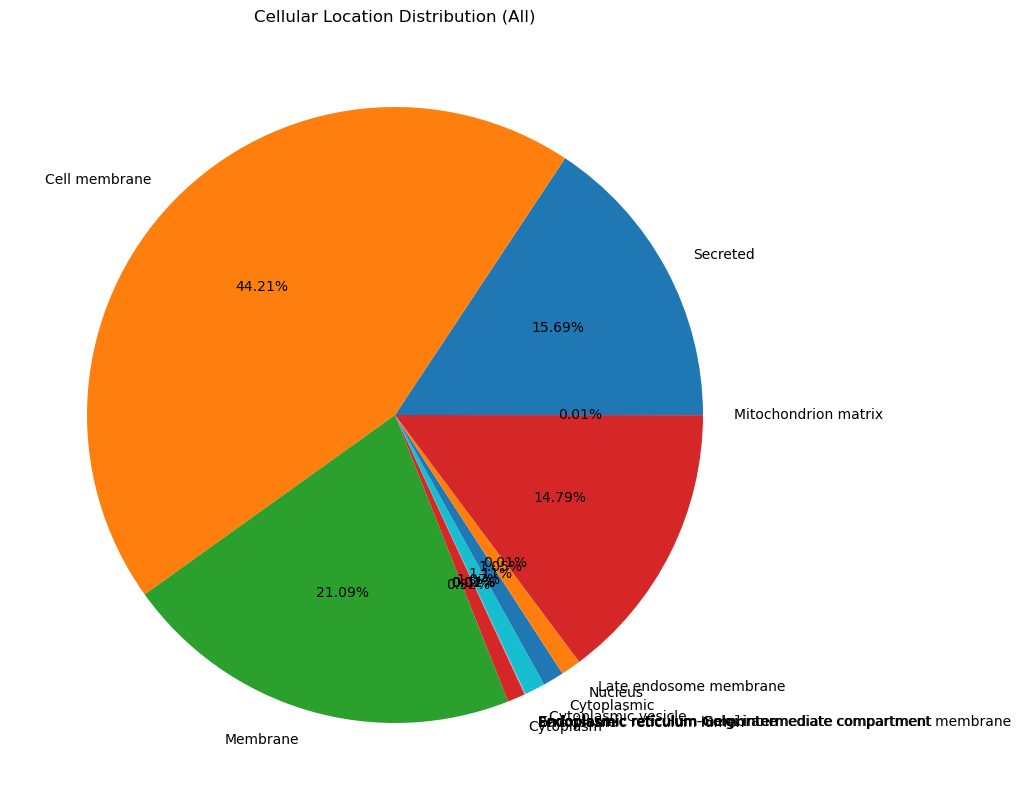

In [25]:
targets_pie_all()

### Zadanie 9

In [26]:
def status_counts():
    currently_approved = 0
    status_counter = {}
    for drug in root.findall('db:drug', ns):
        status = [s.text for s in drug.findall('db:groups/db:group', ns)]
        if ('approved' in status) and not ('withdrawn' in status):
            currently_approved += 1
        for s in status:
            status_counter.setdefault(s, 0)
            status_counter[s] += 1

    print("Approved and not withdrawn total: ", currently_approved)
    return status_counter

In [27]:
def show_pie(counts):
    plt.figure(figsize=(10, 10))
    plt.pie(counts.values(), labels=counts.keys(), autopct='%1.2f%%')
    plt.title("Drug Status Distribution (All)")
    plt.show()

In [28]:
def status_df(counts):
    return pd.DataFrame({"Total": counts.values()}, index=counts.keys())

Approved and not withdrawn total:  19821


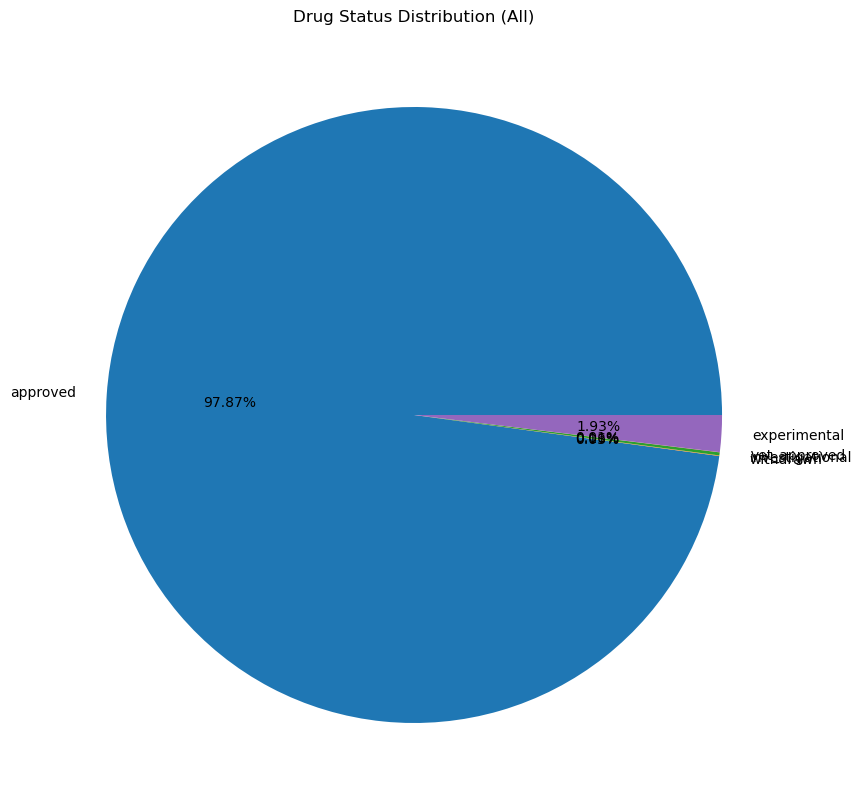

,Total
approved,33046
withdrawn,10
investigational,54
vet_approved,4
experimental,650


In [29]:
counts = status_counts()
show_pie(counts)
status_df(counts)

### Zadanie 10

In [30]:
def target_interactions_df(drug_id):
    drug = root.find(f"db:drug[db:drugbank-id='{drug_id}']", ns)    
    data = []
    index = []
    for target in drug.findall('db:targets/db:target', ns):
        polypeptide = target.find('db:polypeptide', ns)
        index.append(unwrap("id", target))
        data.append({
            "Target": unwrap("name", target),
            "Organism": unwrap("organism", target),
            "Actions": [a.text for a in target.findall('db:actions/db:action', ns)],
            "Known action": unwrap("known-action", target),
            "General Function": unwrap("general-function", polypeptide),
            "Specific Function": unwrap("specific-function", polypeptide),
        })

    return pd.DataFrame(data, index=index)

In [31]:
target_interactions_df("DB00002")

,Target,Organism,Actions,Known action,General Function,Specific Function
BE0000767,Epidermal growth factor receptor,Humans,[binder],yes,Ubiquitin protein ligase binding,Receptor tyrosine kinase binding ligands of th...
BE0000901,Low affinity immunoglobulin gamma Fc region re...,Humans,[binder],unknown,None,Receptor for the Fc region of immunoglobulins ...
BE0002094,Complement C1q subcomponent subunit A,Humans,[binder],unknown,None,C1q associates with the proenzymes C1r and C1s...
BE0002095,Complement C1q subcomponent subunit B,Humans,[binder],unknown,None,C1q associates with the proenzymes C1r and C1s...
BE0002096,Complement C1q subcomponent subunit C,Humans,[binder],unknown,None,C1q associates with the proenzymes C1r and C1s...
BE0002097,Low affinity immunoglobulin gamma Fc region re...,Humans,[binder],unknown,None,Receptor for the Fc region of IgG. Binds compl...
BE0000710,High affinity immunoglobulin gamma Fc receptor I,Humans,[binder],unknown,Receptor signaling protein activity,High affinity receptor for the Fc region of im...
BE0002098,Low affinity immunoglobulin gamma Fc region re...,Humans,[binder],unknown,None,Binds to the Fc region of immunoglobulins gamm...


### Zadanie 11

In [32]:
def gene_graph(gene_name):
    graph = nx.DiGraph()
    graph.add_node(gene_name)
    
    for polypeptide in root.findall(f"db:drug/db:targets/db:target/db:polypeptide[db:gene-name='{gene_name}']", ns):
        drug = polypeptide.find('../../..', ns)
        if drug is None:
            continue
        drug_name = unwrap("name", drug)
        graph.add_edge(gene_name, drug_name)
        for product in drug.findall('db:products/db:product', ns):
            product_str = f"{unwrap('name', product)} ({unwrap('dosage-form', product)})"
            graph.add_edge(drug_name, product_str)
        
    return graph

In [33]:
def visualize_gene(gene_name):
    graph = gene_graph(gene_name)
    
    # pos = nx.bfs_layout(graph, start=gene_name)
    # pos = nx.shell_layout(graph)
    # pos = nx.spring_layout(graph, k=0.3, iterations=100)
    pos = graphviz_layout(graph, prog="twopi")
    
    plt.figure(figsize=(10,10))
    nx.draw(
        graph,
        pos,
        with_labels=True,
        node_size=1000, 
        font_size=8,
        node_color="#dddddd",
        edge_color="#aaaaaa",
    )
    plt.show()

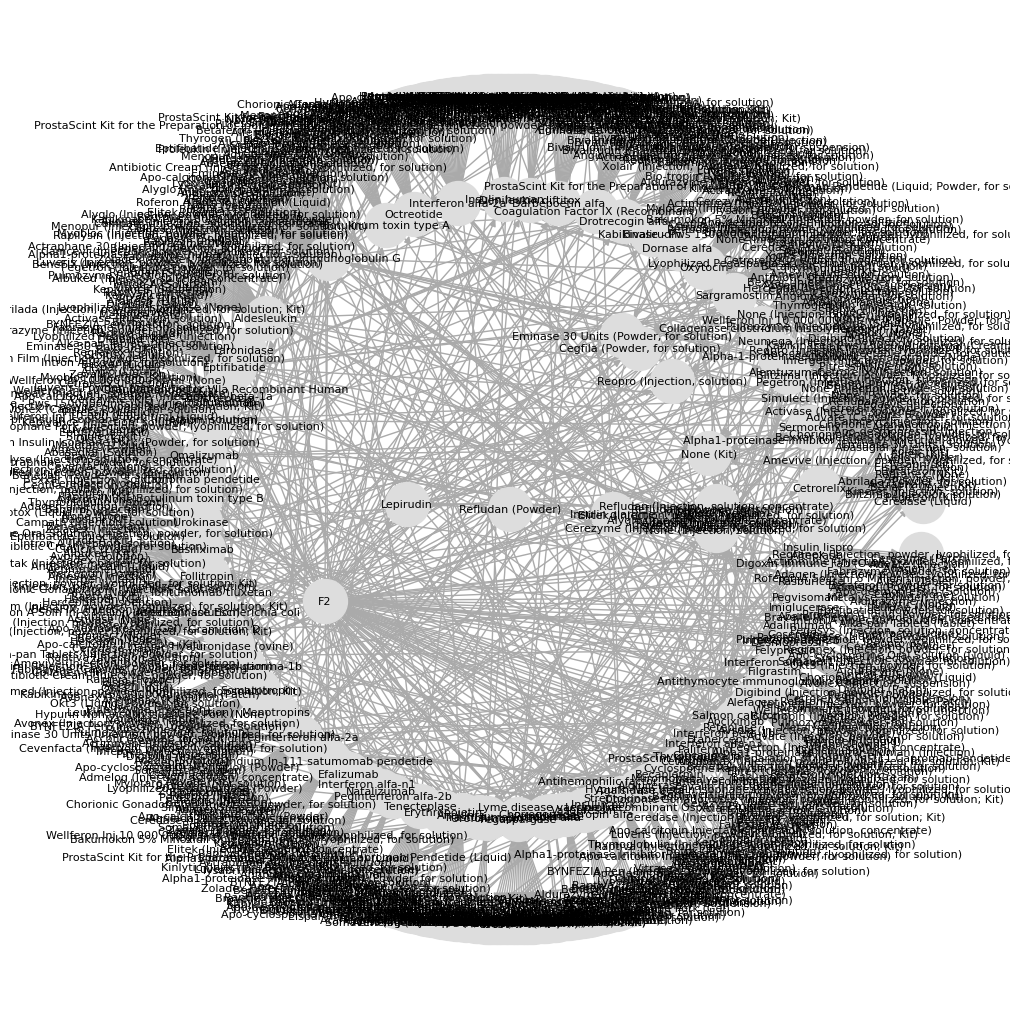

In [34]:
visualize_gene("F2")

In [35]:
def all_genes_df():
    genes = set()
    data = []
    for drug in root.findall('db:drug', ns):
        for polypeptide in drug.findall('db:targets/db:target/db:polypeptide', ns):
            genes.add(unwrap("gene-name", polypeptide))
            data.append({
                "Drug": unwrap("name", drug),
                "Gene": unwrap("gene-name", polypeptide),
            })
    return genes, pd.DataFrame(data)

In [36]:
genes, df = all_genes_df()
df

,Drug,Gene
0,Lepirudin,F2
1,Cetuximab,EGFR
2,Cetuximab,FCGR3B
3,Cetuximab,C1QA
4,Cetuximab,C1QB
...,...,...
18051,Desmopressin,None
18052,Gramicidin D,FCER1A
18053,Gramicidin D,F8
18054,Interferon alfa-n3,None


### Zadanie 12

In [37]:
# helper functions
def twins(iterable):
    return zip(iterable, iterable[1:])

def normalize(string, case_sensitive):
    if case_sensitive or not string:
        return string
    return string[0].upper() + string[1:].lower()

In [38]:
def classification_tree(case_sensitive=False):
    keys = ["root", "kingdom", "superclass", "class", "subclass", "direct-parent"]
    color_list = ["#41afaa", "#466eb4", "#00a0e1", "#e6a532", "#d7642c", "#af4b91"]
    colors = {key: color for key, color in zip(keys, color_list)}
    sizes = {}

    tree = nx.DiGraph()
    
    for classification in root.findall("db:drug/db:classification", ns):
        data = {key: normalize(unwrap(key, classification), case_sensitive) for key in keys}
        data["root"] = "Drugs"
        
        # incomplete data
        if None in data.values(): 
            continue
        
        for key, value in data.items():
            tree.add_node(value, level=key)
            sizes.setdefault(value, 0)
            sizes[value] += 1

        for hi, lo in twins(keys):
            tree.add_edge(data[hi], data[lo])
    
    
    plt.figure(figsize=(10,10))
    plt.title("Drug classification")

    nx.draw(
        tree,
        pos=nx.bfs_layout(tree, start="Drugs", align='horizontal'),
        node_size=[sizes[node] / 20 for node in tree.nodes], 
        with_labels=True,
        node_color=[colors[data['level']] for _, data in tree.nodes(data=True)],
    )
    
    for level, color in colors.items():
        plt.scatter([], [], c=color, label=normalize(level, False))
    plt.legend(title="Hierarchy")

    plt.show()

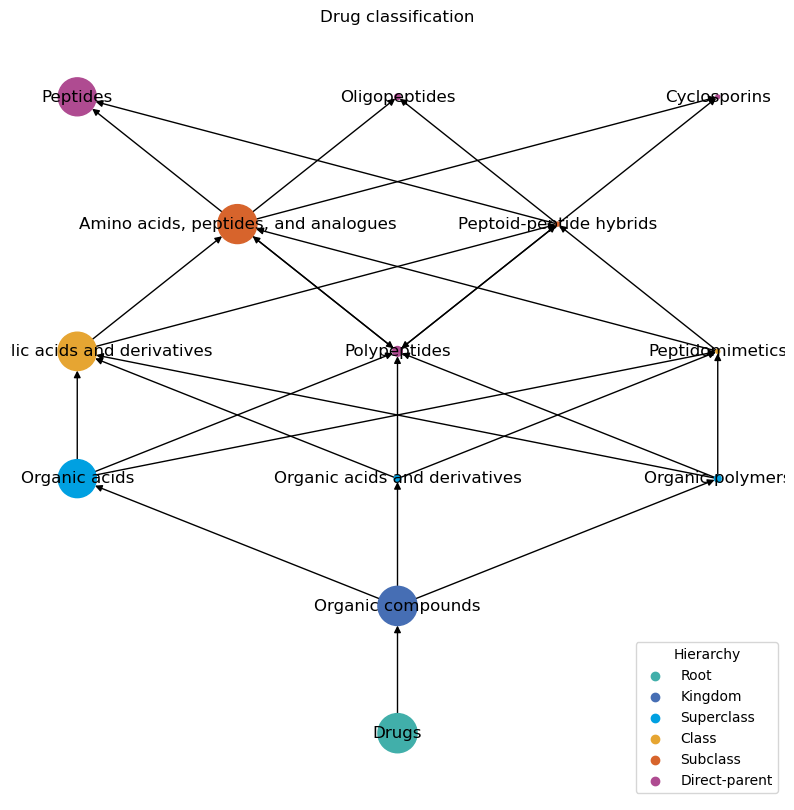

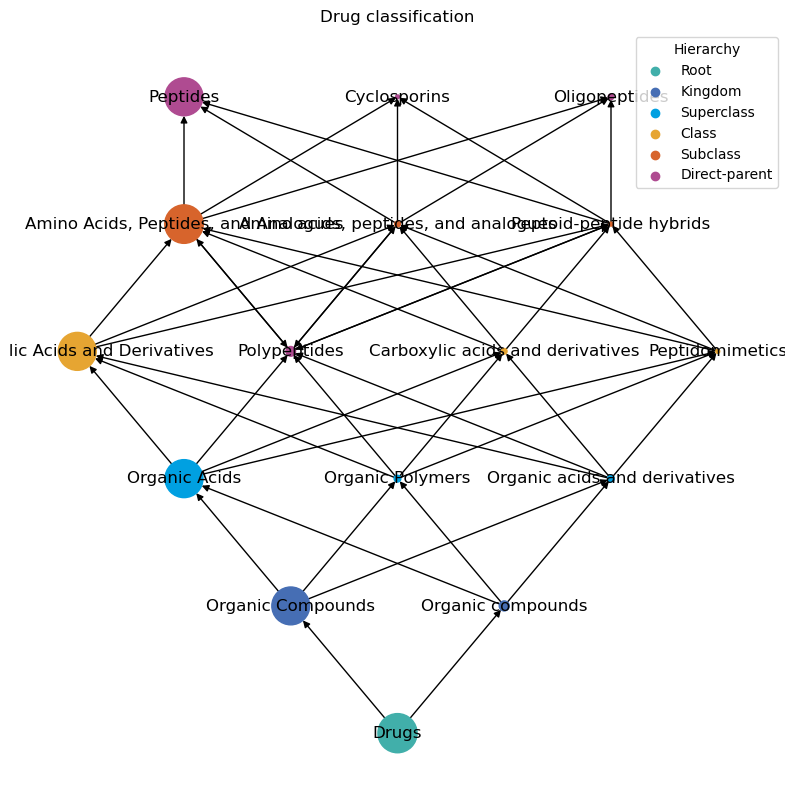

In [39]:
classification_tree()
classification_tree(case_sensitive=True)